In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('adult_dataset.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [2]:
df = df[df['workclass'] != '?']
df = df[df['occupation'] != '?']
df = df[df['native.country'] != '?']
df_categorical = df.select_dtypes(include=['object'])
print(df_categorical.apply(lambda x: x=="?", axis=0).sum())

workclass         0
education         0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
native.country    0
income            0
dtype: int64


In [3]:
from sklearn import preprocessing
df_categorical = df.select_dtypes(include=['object'])
le = preprocessing.LabelEncoder()
df_categorical = df_categorical.apply(le.fit_transform)
df = df.drop(df_categorical.columns, axis=1)
df = pd.concat([df, df_categorical], axis=1)
df['income'] = df['income'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             30162 non-null  int64   
 1   fnlwgt          30162 non-null  int64   
 2   education.num   30162 non-null  int64   
 3   capital.gain    30162 non-null  int64   
 4   capital.loss    30162 non-null  int64   
 5   hours.per.week  30162 non-null  int64   
 6   workclass       30162 non-null  int64   
 7   education       30162 non-null  int64   
 8   marital.status  30162 non-null  int64   
 9   occupation      30162 non-null  int64   
 10  relationship    30162 non-null  int64   
 11  race            30162 non-null  int64   
 12  sex             30162 non-null  int64   
 13  native.country  30162 non-null  int64   
 14  income          30162 non-null  category
dtypes: category(1), int64(14)
memory usage: 3.5 MB


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('income', axis=1)
y = df['income'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=99)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (21113, 14)
Test set size: (9049, 14)


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create and train model
dt_default = DecisionTreeClassifier(max_depth=5, random_state=100)
dt_default.fit(X_train, y_train)

# Make predictions
y_pred_default = dt_default.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_default))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_default))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_default):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      6867
           1       0.78      0.52      0.63      2182

    accuracy                           0.85      9049
   macro avg       0.82      0.74      0.77      9049
weighted avg       0.84      0.85      0.84      9049


Confusion Matrix:
[[6553  314]
 [1039 1143]]

Accuracy: 0.8505


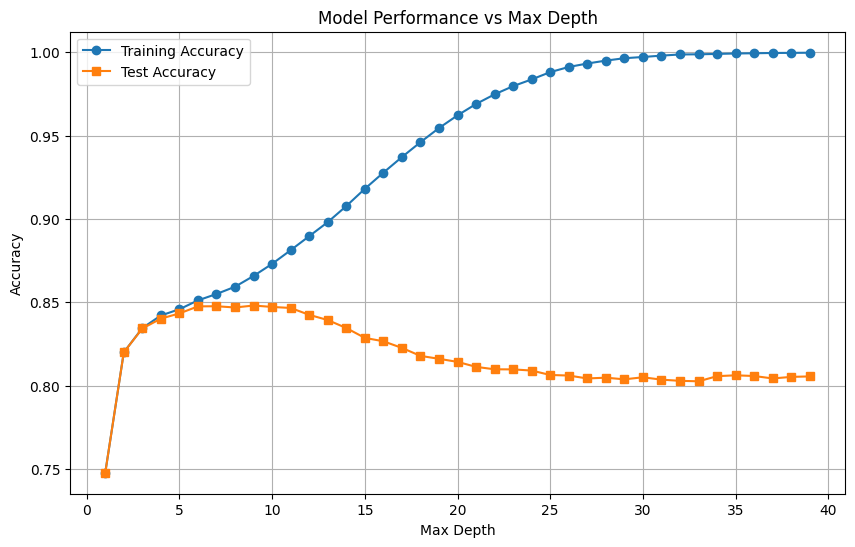

Best max_depth: 9


In [12]:
from sklearn.model_selection import GridSearchCV, KFold

n_folds = 5
parameters = {'max_depth': range(1, 40)}

dtree = DecisionTreeClassifier(criterion="gini", random_state=100)
tree = GridSearchCV(dtree, parameters, cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
tree.fit(X_train, y_train)

# Plot results
scores = tree.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(scores["param_max_depth"], scores["mean_train_score"], 
         label="Training Accuracy", marker='o')
plt.plot(scores["param_max_depth"], scores["mean_test_score"], 
         label="Test Accuracy", marker='s')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Model Performance vs Max Depth")
plt.legend()
plt.grid()
plt.show()

print(f"Best max_depth: {tree.best_params_['max_depth']}")

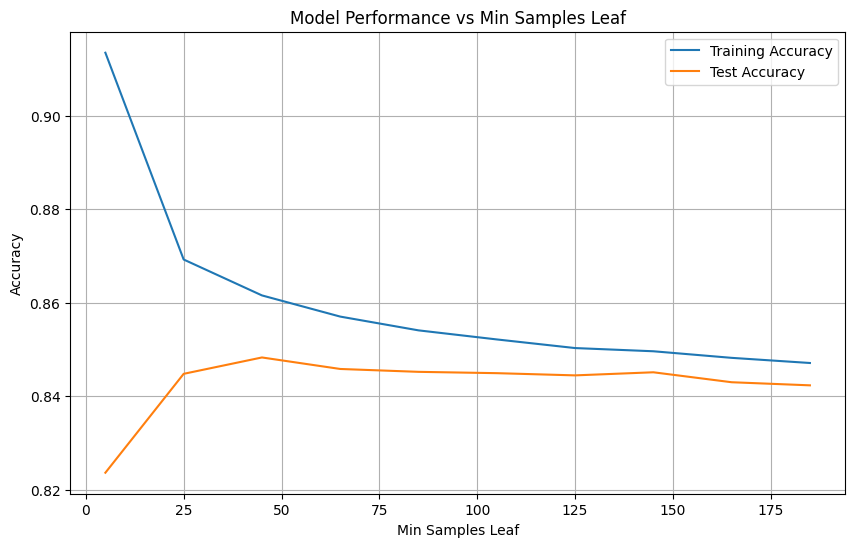

In [13]:
parameters = {'min_samples_leaf': range(5, 200, 20)}

dtree = DecisionTreeClassifier(criterion="gini", random_state=100)
tree = GridSearchCV(dtree, parameters, cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
tree.fit(X_train, y_train)

scores = tree.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(scores["param_min_samples_leaf"], scores["mean_train_score"], 
         label="Training Accuracy")
plt.plot(scores["param_min_samples_leaf"], scores["mean_test_score"], 
         label="Test Accuracy")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Accuracy")
plt.title("Model Performance vs Min Samples Leaf")
plt.legend()
plt.grid()
plt.show()

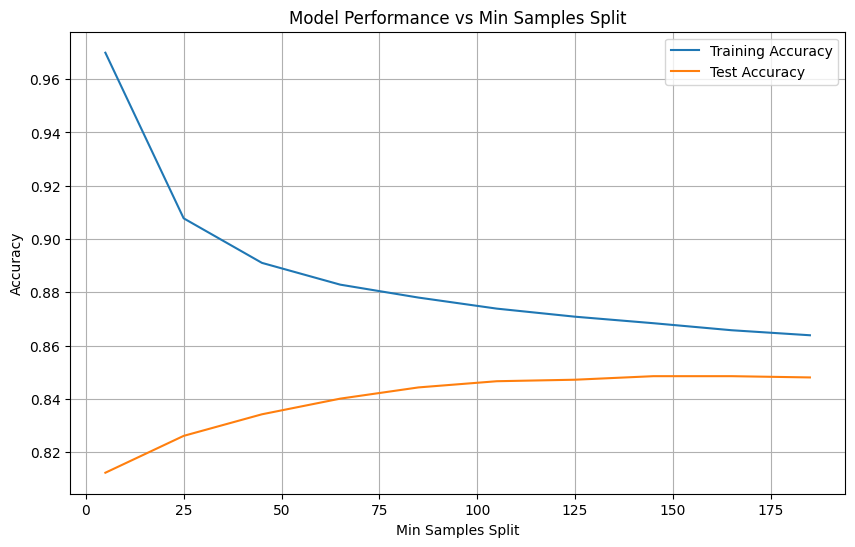

In [14]:
parameters = {'min_samples_split': range(5, 200, 20)}

dtree = DecisionTreeClassifier(criterion="gini", random_state=100)
tree = GridSearchCV(dtree, parameters, cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
tree.fit(X_train, y_train)

scores = tree.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(scores["param_min_samples_split"], scores["mean_train_score"], 
         label="Training Accuracy")
plt.plot(scores["param_min_samples_split"], scores["mean_test_score"], 
         label="Test Accuracy")
plt.xlabel("Min Samples Split")
plt.ylabel("Accuracy")
plt.title("Model Performance vs Min Samples Split")
plt.legend()
plt.grid()
plt.show()

In [15]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

dtree = DecisionTreeClassifier(random_state=100)
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, 
                          cv=n_folds, verbose=1, return_train_score=True)
grid_search.fit(X_train, y_train)

print(f"Best accuracy: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"\nBest model:\n{grid_search.best_estimator_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best accuracy: 0.8510
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50}

Best model:
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)


In [16]:
clf_final = DecisionTreeClassifier(
    criterion="gini", 
    random_state=100,
    max_depth=10, 
    min_samples_leaf=50,
    min_samples_split=50
)
clf_final.fit(X_train, y_train)

# Test the model
y_pred_final = clf_final.predict(X_test)

print("Final Model Performance:")
print(f"Test Accuracy: {clf_final.score(X_test, y_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

Final Model Performance:
Test Accuracy: 0.8509

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6867
           1       0.73      0.60      0.66      2182

    accuracy                           0.85      9049
   macro avg       0.81      0.77      0.78      9049
weighted avg       0.84      0.85      0.85      9049


Confusion Matrix:
[[6383  484]
 [ 865 1317]]


In [17]:
clf_simple = DecisionTreeClassifier(
    criterion="gini", 
    random_state=100,
    max_depth=3, 
    min_samples_leaf=50,
    min_samples_split=50
)
clf_simple.fit(X_train, y_train)

print(f"Simplified Model Accuracy: {clf_simple.score(X_test, y_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, clf_simple.predict(X_test)))

Simplified Model Accuracy: 0.8393

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      6867
           1       0.77      0.47      0.59      2182

    accuracy                           0.84      9049
   macro avg       0.81      0.71      0.74      9049
weighted avg       0.83      0.84      0.82      9049

